<a href="https://colab.research.google.com/github/prasanth59/Work/blob/master/Post_Wise_chunking_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # !pip install contractions
# !pip install langdetect

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
!cp "/content/drive/MyDrive/blog_post_wise_dict.pickle"  "/content/blog_post_wise_dict.pickle" 
# !unzip '/content/blogs.zip'

In [6]:
from bs4 import BeautifulSoup
import os 
import pandas as pd
# import contractions
import nltk
from nltk.tokenize import sent_tokenize
# from spacy.lang.en.stop_words import STOP_WORDS
import pickle
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Extract content from post tag in blog

In [ ]:
def get_file_content(path,file_names):
  """Returns blog content in <p> tags in html file """
  file_text = {}
  # blog_records = []
  for file_name in file_names:
    posts_list = []
    # blog_records.append(file_name.strip().split(".")[:-1])
    # print(file_name)
    # print(blog_records)
    try:
      with open(path+file_name, "r",encoding="ISO-8859-1") as file_obj:
        contents = file_obj.read()
        soup = BeautifulSoup(contents, 'lxml')
        for tag in soup.find_all("post"):
          temp = tag.text.replace("\\", "").replace("\t",'').replace("\n",'').replace('urlLink','').lower()
          if len(temp.split()) > 10:
            temp = ' '.join([(contractions.fix(word)) for word in temp.split()])
            posts_list.append(temp)
    except IOError:
      print("Error: Input XML files not found ")
    # print(file_name.strip().split(".")[0])
    file_text[file_name.strip().split(".")[0]] = posts_list
  return file_text

In [ ]:
path = '/content/blogs/'
files_list = os.listdir(path)
file_chunk_content = get_file_content(path,files_list)
pickle.dump(file_chunk_content,open('en_chunk_wise_dict.pickle','wb'),protocol= pickle.HIGHEST_PROTOCOL)

In [47]:
# Method to detect the non english blogs in the corpus
def remove_non_english_blog(file_dict):
  non_en = []
  for key in file_dict.keys():
    try:
      lang = detect(file_dict[key])
      if lang!= 'en':
        # print(lang,key)
        non_en.append(key)
    except :
      print('Error in Key value',key)
      non_en.extend(key)
      continue
  
  for key in non_en:
    try:
      file_dict.pop(key)
    except:
       print('Error in Key value',key)
       continue

  return file_dict

file_chunk_content = remove_non_english_blog(file_chunk_content)

# Perform preprocessing on the extracted chunks(posts) from blogs

In [34]:
# Method to set spacy preprocessing pipeline
def set_preprocess_pipeline():
  spacy_pipeline = spacy.load('en_core_web_sm')
  sentencizer = spacy_pipeline.create_pipe('sentencizer')
  spacy_pipeline.add_pipe(sentencizer)
  return spacy_pipeline

# Remove the punctuations from the sentences
def remove_punctuation(content):
  return ' '.join([token for token in content.split() if token.isalpha() == True])

# Mehtod to perform preprocessing task
def preprocess_text(blog_text):
  sentences = nltk.sent_tokenize(blog_text)
  sentences = [remove_punctuation(sentence) for sentence in sentences]
  sentences = ' '.join(sentences)
  return sentences

In [2]:
# preprocess_pipeline = set_preprocess_pipeline()
file_chunk_content = pickle.load(open('en_chunk_wise_dict.pickle','rb'))
# sample_blogs = file_content.keys()
# file_content = pickle.load(open('/content/english_blog_corpus_dict.pickle','rb'))

In [69]:
 sample_blogs = list(file_chunk_content.keys())[3000]

In [ ]:
testing_blogs = {}
for key in list(file_chunk_content.keys())[:3000]:
  testing_blogs[key] = list(map(preprocess_text,file_chunk_content[key]))
  print(key)

In [35]:
list(map(preprocess_text,file_chunk_content['1009572']))
# file_chunk_content['1009572'][0]


['planning the marathon i checked and the registration for the spirit of louis marathon does not open until august I am planning to get online at and i like doing triathlons andwill probably sign up for another one next but i think that I am going to make running my primary focus for the next months after the starting with the i think I am going to find a for and maybe join the stl track club for their winter race',
 'i must be crazy here i less than months from my first ever race spirit of louis and now I have signed up for the lewis clark on I am trying to work up to the spirit of louis then i want to run an ultra next i think i can do it is a road at I am looking forward to increasing my mileage this is the start of my blog to chronicle my training to reach these',
 'running in forest park there is a mile loop is actually about at forest park in the louis triathlon club runs there every wednesday at and as a i try to get out to run with one way around the park goes up a long hill pa

In [68]:
pickle.dump(testing_blogs,open('2k_processed_dict.pickle','wb'),protocol= pickle.HIGHEST_PROTOCOL)
!cp "/content/2k_processed_dict.pickle" "/content/drive/MyDrive/2k_processed_dict.pickle" 

# Generate embeddings for each post (chunk) in the blog

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder/3"
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.load(module_url)

In [ ]:
blog_embedding = {}
for key in testing_blogs.keys():
  # print(key)
  blog_embedding [key] = [embed([post])['outputs'].numpy().reshape(1,-1) for post in testing_blogs[key]]

In [ ]:
query = 'purchasing'
embed_query = embed([query])['outputs'][0].numpy().reshape(1,-1)

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
similarity = {}
for key in blog_embedding.keys():
  post_sim  = []
  for item in blog_embedding[key]:
    # print(item.shape,embed_query.shape)
    # print(type(item),type(embed_query))
    # print(item)
    # break
    post_sim.append(cosine_similarity(item.reshape(1,-1),embed_query))
  similarity[key] = (np.max(post_sim),np.argmax(post_sim))
  # similarity[key] = (np.mean(post_sim))
  # break
# embed_query['outputs'][0]


In [ ]:
similarity = sorted(similarity.items(), key=lambda x: x[1], reverse=True)

In [ ]:
similarity[:10]

[('3575321', 0.08983934),
 ('4295610', 0.06506164),
 ('3479663', 0.0611583),
 ('3962694', 0.059156228),
 ('4209630', 0.053669903),
 ('4258946', 0.04933091),
 ('3454837', 0.04541669),
 ('4230427', 0.044803362),
 ('3649624', 0.044762306),
 ('4170988', 0.044217914)]

In [ ]:
[('3575321', (0.2885018, 0)),
 ('2784121', (0.23606962, 14)),
 ('2652964', (0.22985673, 85)),
 ('3529406', (0.21925841, 150)),
 ('1449141', (0.21860936, 410)),
 ('1056232', (0.20585573, 550)),
 ('2600593', (0.2000128, 53)),
 ('3663542', (0.19867145, 9)),
 ('1977468', (0.19416338, 89)),
 ('78196', (0.19256797, 207))]

In [ ]:
testing_blogs['78196'][207]

'addiction i need help i need help now ebay is going to because me to go broke and get thrown out of my apartment the first sign of an addiction is denial been there done that so I am guessing I am worse off than i thought i do not know but i can not stay away from ebay all day i bid buy bid buy search click bid and buy why shit like this and this and oh god this makes you addicted to ebay I am a shopaholic by nature but i have not been to the malls lately because all of my shit comes from ebay i feel like a prisoner in my own home because I am do not have to leave to get good stuff oh please call the authorities now'

In [ ]:
sample_sentences = ['I am always interested in reading',
                    'It is so cold outside',
                    'I purchased books','NLP is interesting','sentence encoder gives embeddings']
# query_term = []
# sample_query_embedding = embed(query_term)['outputs'][0].numpy().reshape(1,-1)
sample_sentence_embedding = [ embed([item])['outputs'][0].numpy().reshape(1,-1) for item in sample_sentences ]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Use PCA to reduce the dimensions of the embedding
def pca_transform(sentence_embeddings,dim):
    vectors = np.vstack((sentence_embeddings[0], sentence_embeddings[1], sentence_embeddings[2]))
    # Set the number of dimensions PCA will reduce to
    pca = PCA(n_components=dim)
    pca.fit(vectors)
    new_pca = pca.transform(vectors)
    print("original shape:   ", vectors.shape)
    print("transformed shape:", new_pca.shape)
    return(new_pca)

new_dim = pca_transform(sample_sentence_embedding, 2)

original shape:    (3, 512)
transformed shape: (3, 2)


In [ ]:
# Draw a 2d graph with the new dimensions
def two_d_graph(sample_sentences,reduced_dims):
    colors = ("red", "green", "blue")
    groups = (sample_sentences[0], sample_sentences[1], sample_sentences[2]) 
 
    # Create plot
    fig = plt.figure()
    ax = fig.gca()
 
    for data, color, group in zip(reduced_dims, colors, groups):
        x, y = data
        ax.scatter(x, y, c=color, edgecolors='none', s=30, label=group)
 
    plt.title('Plot of sentence embeddings')
    plt.legend(loc=1)
    plt.rcParams["figure.figsize"] = (8,15)
    plt.show()

two_d_graph(sample_sentences,new_dim)

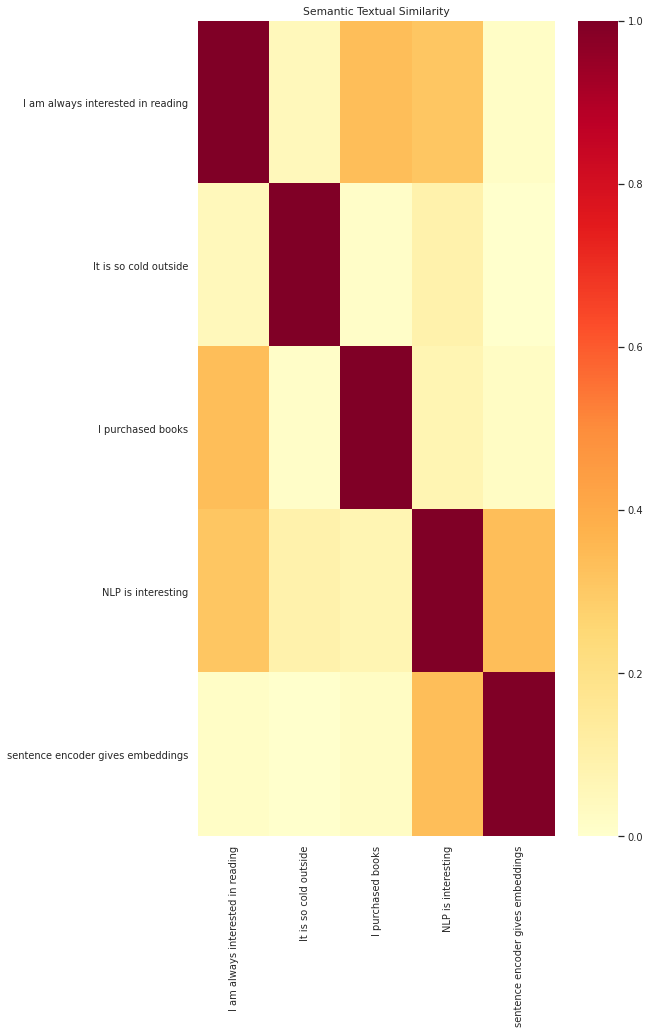

In [ ]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features).reshape(len(labels),len(labels))
  sns.set(font_scale=0.9)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")
  # print(corr)

def run_and_plot(sentences,embeddings):
  # message_embeddings_ = embed(messages_)
  plot_similarity(sentences, embeddings, 90)

run_and_plot(sample_sentences,sample_sentence_embedding)